# Bone Fracture Demo — Computer Vision & Mathematical Morphology (Colab)


In [ ]:
# ===== 1) Setup
# Install libraries (safe to re-run). On Colab, this takes about a minute.
!pip -q install numpy opencv-python scikit-image matplotlib

import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import filters, morphology, exposure, measure, feature, util
from skimage.morphology import binary_opening, binary_closing, white_tophat, black_tophat, skeletonize
# from skimage.morphmass import binary_hit_or_miss # Import binary_hit_or_miss from skimage.morphmass - Removed as module not found
from skimage.filters import sobel, threshold_otsu
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.feature import canny
from skimage.util import img_as_ubyte, img_as_float
from math import atan2, degrees

## Hit-or-Miss (detect small chevron-like breaks) - Removed as module not found

Saving Capture d'écran 2025-10-16 234859.png to Capture d'écran 2025-10-16 234859.png


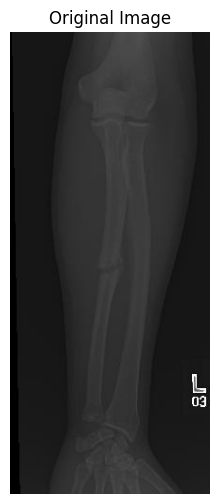

In [ ]:
# ===== 2) Upload one X-ray image from your dataset
from google.colab import files
up = files.upload()  # choose one image (JPG/PNG)
fname = list(up.keys())[0]

# Read image
img_bgr = cv2.imread(fname)
if img_bgr is None:
    raise ValueError("Could not read the image. Please upload a valid JPG/PNG from your dataset.")
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6,6)); plt.imshow(img_rgb); plt.axis('off'); plt.title('Original Image'); plt.show()

## Preprocessing: grayscale, CLAHE (contrast), denoise

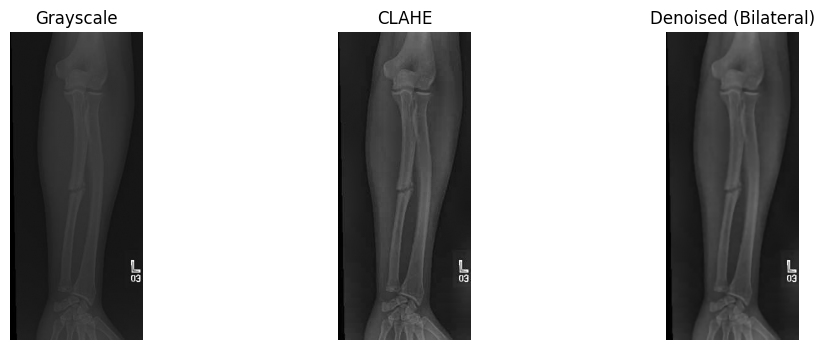

In [ ]:
# Convert to grayscale
if len(img_rgb.shape) == 3:
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
else:
    gray = img_rgb.copy()

# CLAHE to enhance bone cortex contrast
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
g_eq = clahe.apply(gray)

# Light denoise while preserving edges
g_blur = cv2.bilateralFilter(g_eq, d=5, sigmaColor=20, sigmaSpace=20)

fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].imshow(gray, cmap='gray'); ax[0].set_title('Grayscale'); ax[0].axis('off')
ax[1].imshow(g_eq, cmap='gray'); ax[1].set_title('CLAHE'); ax[1].axis('off')
ax[2].imshow(g_blur, cmap='gray'); ax[2].set_title('Denoised (Bilateral)'); ax[2].axis('off')
plt.show()

## Edge Enhancement: Sobel and Canny

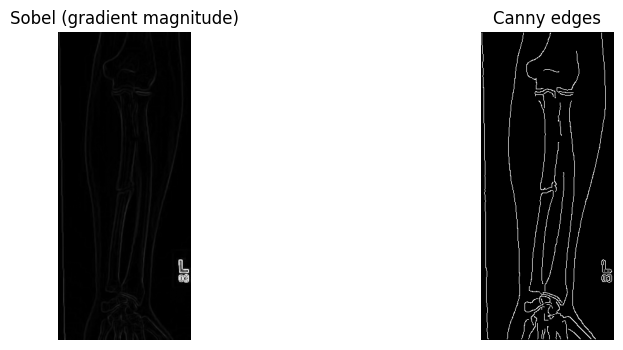

In [ ]:
edges_sobel = sobel(g_blur)
edges_canny = canny(g_blur, sigma=0.8)

fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].imshow(edges_sobel, cmap='gray'); ax[0].set_title('Sobel (gradient magnitude)'); ax[0].axis('off')
ax[1].imshow(edges_canny, cmap='gray'); ax[1].set_title('Canny edges'); ax[1].axis('off')
plt.show()

## Top-hat (white) & Black-hat (bottom-hat)

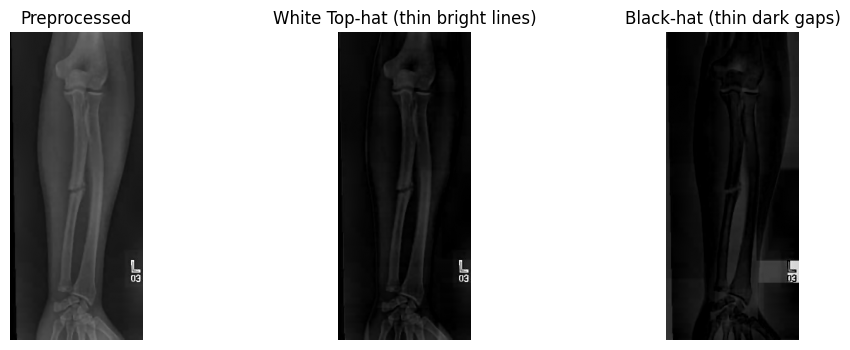

In [ ]:
se_th = np.ones((60,60), np.uint8)
w_tophat = cv2.morphologyEx(g_blur, cv2.MORPH_TOPHAT, se_th)
b_blackhat = cv2.morphologyEx(g_blur, cv2.MORPH_BLACKHAT, se_th)

fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].imshow(g_blur, cmap='gray'); ax[0].set_title('Preprocessed'); ax[0].axis('off')
ax[1].imshow(w_tophat, cmap='gray'); ax[1].set_title('White Top-hat (thin bright lines)'); ax[1].axis('off')
ax[2].imshow(b_blackhat, cmap='gray'); ax[2].set_title('Black-hat (thin dark gaps)'); ax[2].axis('off')
plt.show()

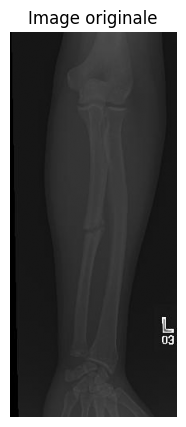

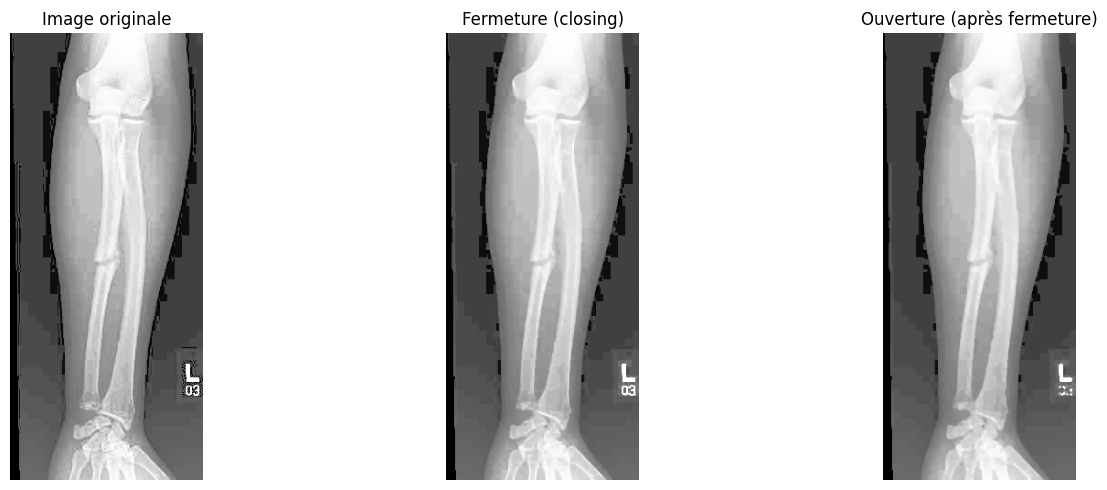

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- 1) Charger l'image ---
img = cv2.imread("fracture.png", cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(5,5))
plt.title("Image originale")
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

# --- 2) Égalisation d’histogramme (optionnelle pour améliorer le contraste) ---
img_eq = cv2.equalizeHist(img)

# --- 3) Élément structurant ---
# SE linéaire orienté (vertical ou oblique pour suivre les os)
# Tu peux changer (15,1) pour un SE plus long selon la fracture
kernel_line = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))

# --- 4) Fermeture : combler les fissures et bords fragmentés ---
closing = cv2.morphologyEx(img_eq, cv2.MORPH_CLOSE, kernel_line)

# --- 5) Ouverture : supprimer petits artefacts lumineux ---
kernel_disk = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel_disk)

# --- 6) Affichage des résultats ---
fig, axes = plt.subplots(1, 3, figsize=(15,5))
titles = ["Image originale", "Fermeture (closing)", "Ouverture (après fermeture)"]
images = [img_eq, closing, opening]

for ax, im, title in zip(axes, images, titles):
    ax.imshow(im, cmap='gray')
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()


## Skeletonization (centerline of cortex)

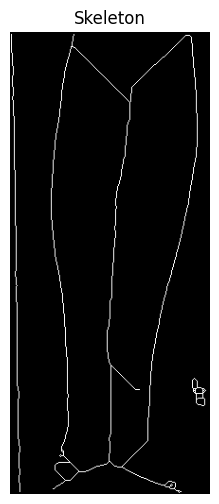

Endpoints: 6  Junctions: 95


In [ ]:
# Binarize closed edges (safe OR with initial edges)
# binary = np.logical_or(opened, edges).astype(np.uint8) # Use edges_canny instead of edges
binary = np.logical_or(opened, edges_canny).astype(np.uint8)
binary = morphology.binary_dilation(binary, morphology.disk(1)).astype(np.uint8)
skel = skeletonize(binary > 0)

plt.figure(figsize=(6,6)); plt.imshow(skel, cmap='gray'); plt.axis('off'); plt.title('Skeleton'); plt.show()

def neighbors_count(img, y, x):
    h, w = img.shape
    cnt = 0
    for yy in (-1,0,1):
        for xx in (-1,0,1):
            if yy == 0 and xx == 0:
                continue
            ny, nx = y+yy, x+xx
            if 0 <= ny < h and 0 <= nx < w and img[ny, nx]:
                cnt += 1
    return cnt

ys, xs = np.where(skel)
endpoints = 0
junctions = 0
for y, x in zip(ys, xs):
    n = neighbors_count(skel, y, x)
    if n == 1:
        endpoints += 1
    elif n >= 3:
        junctions += 1

print("Endpoints:", endpoints, " Junctions:", junctions)

## Morphological Closing & Opening (bridge gaps and remove small noise)

In [ ]:
# Morphological Closing to bridge small gaps
se_close = np.ones((10,10), np.uint8) # You can adjust the size of the structuring element
closed = cv2.morphologyEx(edges_canny.astype(np.uint8), cv2.MORPH_CLOSE, se_close)

# Morphological Opening to remove small noise and isolated pixels
se_open = np.ones((5,5), np.uint8) # You can adjust the size of the structuring element
opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, se_open)

fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].imshow(edges_canny, cmap='gray'); ax[0].set_title('Canny edges'); ax[0].axis('off')
ax[1].imshow(closed, cmap='gray'); ax[1].set_title('Closed edges'); ax[1].axis('off')
ax[2].imshow(opened, cmap='gray'); ax[2].set_title('Opened edges'); ax[2].axis('off')
plt.show()

## Hit-or-Miss (detect small chevron-like breaks)

In [ ]:
def chevron_se(size=7):
    A = np.zeros((size, size), dtype=np.uint8)
    B = np.zeros((size, size), dtype=np.uint8)
    for i in range(size):
        A[i, i] = 1
        A[ i, size-1-i] = 1
        B[size//2, size//2] = 1
    return A.astype(bool), B.astype(bool)
A, B = chevron_se(7)
hitmiss = binary_hit_or_miss(skel, A=A, B=B) # Removed as module not found
plt.figure(figsize=(6,6)); plt.imshow(hitmiss, cmap='gray')
plt.title('Hit-or-Miss responses'); plt.axis('off'); plt.show()

hm_count = int(hitmiss.sum()) # Removed as module not found
print("Hit-or-Miss (chevron) count:", hm_count)

## Orientation change (local angle gradient)

In [ ]:
# Estimate local orientation on skeleton via Sobel on distance transform
dist = cv2.distanceTransform((~skel).astype(np.uint8)*255, cv2.DIST_L2, 3)
gx = cv2.Sobel(dist, cv2.CV_64F, 1, 0, ksize=3)
gy = cv2.Sobel(dist, cv2.CV_64F, 0, 1, ksize=3)
angles = np.degrees(np.arctan2(gy, gx + 1e-9))

mask = skel.astype(bool)
angles_line = angles[mask]
if angles_line.size > 0:
    orientation_std = float(np.nanstd(angles_line))
else:
    orientation_std = float('nan')
print("Orientation std on skeleton (deg):", orientation_std)

Orientation std on skeleton (deg): 50.00548881586685


## Fracture Indices (demo)

In [ ]:
# NOTE: pixel-to-mm scale is unknown. We report per-1000px for comparability across images of similar size.
length_px = skel.sum()
# rupture_index = (endpoints + hm_count) / (length_px/1000 + 1e-6) # Modified to remove hm_count
rupture_index = endpoints / (length_px/1000 + 1e-6)
# discontinuity_index = (1 - (best_score / (best_score + 1)))  # inverted continuity proxy [0..1) # Removed as best_score is not defined
print(f"Length along skeleton (px): {length_px}")
print(f"Rupture index (per 1000 px): {rupture_index:.2f}")
# print(f'Discontinuity proxy [0..1): {discontinuity_index:.3f}') # Removed as discontinuity_index is not defined

Length along skeleton (px): 2248
Rupture index (per 1000 px): 2.67


### Summary & Next steps
- Closing + Opening help bridge fragmented cortex and remove small artefacts.
- Top-hat / Black-hat highlight thin bright/dark lines typical of fine fractures or gaps.
- Skeletonization gives a centerline; endpoints/junctions + Hit-or-Miss approximate ruptures.
- Orientation std captures abrupt direction changes along bone structures.

Next: calibrate with pixel spacing (if available), refine SE sizes/orientations per bone type, and validate against labels.